In [22]:
import os 
import numpy as np 
from PIL import Image 
import matplotlib.pyplot as plt 
from tqdm import tqdm

from utils.image import crop,norm
from utils.plots import imshowgray, imshowpair, plotbbox
from utils.fourier import phasorFFT,IFT2Dc,FT2Dc,Propagator
from utils.detection import xywh_xyxy,xyxy_xywh_norm,createTxt

In [12]:
def createCanvasBreaking(N,PathClasses,Path,nb,itermax=20):
    """
    Simulate the canvas from ROIs
    
    Parameters
    ----------
    N : int
        image size.
    PathClasses : list
        names of the classes .
    Path : str
        main path eg ('./dataset/train/').
    nb : int
        number of plancton from 1 class to be added on the canvas .
    itermax : int
        number of iteration before breaking.

    Returns
    -------
    Canvas.

    """
    
    Coor = []
    Classe = []
    ImagesPath = []
    CL = []
    
    Canvas = np.ones((N,N))
    a = np.ones((N,N))
    
    for k in range(len(PathClasses)):
        listing = os.listdir(Path+PathClasses[k])
        IDs = np.random.randint(0,len(listing),nb)
        for m in range(nb):
            Classe.append(k)
        for idx in IDs :
            ImagesPath.append( Path +PathClasses[k] +"\\"+ listing[idx])
            
        
    
    for ID in range(0,len(ImagesPath)):
        image = np.array(Image.open(ImagesPath[ID]))
        imcrop = crop(image)
        rot = np.random.randint(0,4) # 0,1,2,3
        flip = np.random.randint(-1,2) #-1,0,1
        if rot!=0 :
            imcrop = np.rot90(imcrop,rot)

        if flip !=-1:
            imcrop = np.flip(imcrop,flip)
        h,w = imcrop.shape 
        
        # NO overlaping condition 
        p = np.where(a==1)
        idx = np.random.randint(len(p[0])) # find empty space 
        posi_y = p[0][idx]
        posi_x = p[1][idx]
        b = np.ones((N,N))
        b[posi_y:posi_y+h,posi_x:posi_x+w] = 0
        c  = a.astype(bool)|b.astype(bool) # if c==False overlapping objects 

        k = 0
        rep = False
        while (posi_y+h>N) | (posi_x+w>N) | (len(np.where(c==0)[0])>0) :
            if k >itermax:
                rep = True
                print('breaking')
                break
            k +=1
            idx = np.random.randint(len(p[0]))
            posi_y = p[0][idx]
            posi_x = p[1][idx]
            b = np.ones((N,N))
            b[posi_y:posi_y+h,posi_x:posi_x+w] = 0
            c  = a.astype(bool)|b.astype(bool)
            c = c.astype(int)
        # end overlaping condition
        
        if rep!=True:
            c  = a.astype(bool)|b.astype(bool) # update binary mask
            a[posi_y:posi_y+h,posi_x:posi_x+w]=0


            ### simulate transmission function
            imcrop = imcrop/255
            t = -1*imcrop+1
            val_abs =  np.random.randint(70,100)*1e-2
            imcrop = np.exp(-val_abs*t)


            Canvas[posi_y:posi_y+h,posi_x:posi_x+w]=imcrop
            CL.append(Classe[ID])
            xnorm,ynorm, wnorm, hnorm = xyxy_xywh_norm(posi_x,posi_y,posi_x+w,posi_y+h,N)
            Coor.append([xnorm,ynorm, wnorm, hnorm])
    return(Canvas,Coor,CL)
    


def simulationHolo(Canvas,pixelsize,Lambda,z):
    '''
    Simulate the hologram from Canvas
    
    Parameters
    ----------
    Canvas : ndarray NxN
    pixelsize : float
        pixel size of the camera in meter
    Lambda : float
        wavelength in meter 
    z : float
        distance object/camera in meter 

    Returns
    -------
    holo.

    '''
    # padding 
    N = len(Canvas)
    x = np.ones((2*N,2*N))
    M = round(N/2)
    x[M:-M,M:-M]= Canvas
    x = norm(x)

    # 
    area = 2*N*pixelsize
    prop = Propagator(2*N,Lambda,area,z)
    f = phasorFFT(2*N)


    # simulation of the holo
    U =  IFT2Dc(FT2Dc(x,f)*np.conj(prop),f)
    holo = abs(U)**2

    holo = holo[M:-M,M:-M]

    holo = norm(holo)
    return(holo)

#%%

In [13]:
Lambda = 520e-9
pixelsize = 1.12e-6
z  = 0.8e-3

Path = "dataset/train/"
PathClasses = ['hydromedusae_solmaris',
 'P16',
 'chaetognath_sagitta',
 'trichodesmium_puff',
 'echinoderm_larva_seastar_brachiolaria',
 'diatom_chain_tube',
 'P17',
 'acantharia_protist',
 'copepod_calanoid',
 'appendicularian_s_shape',
 'P1',
 'copepod_cyclopoid_oithona',
 'protist_noctiluca']

# Simulate 1 hologram

In [15]:
nb = 1
N = 512
Canvas,Coor,Classe = createCanvasBreaking(N,PathClasses,Path,nb)
Holo = simulationHolo(Canvas,pixelsize,Lambda,z)

# Show the canvas and the corresponding hologram 

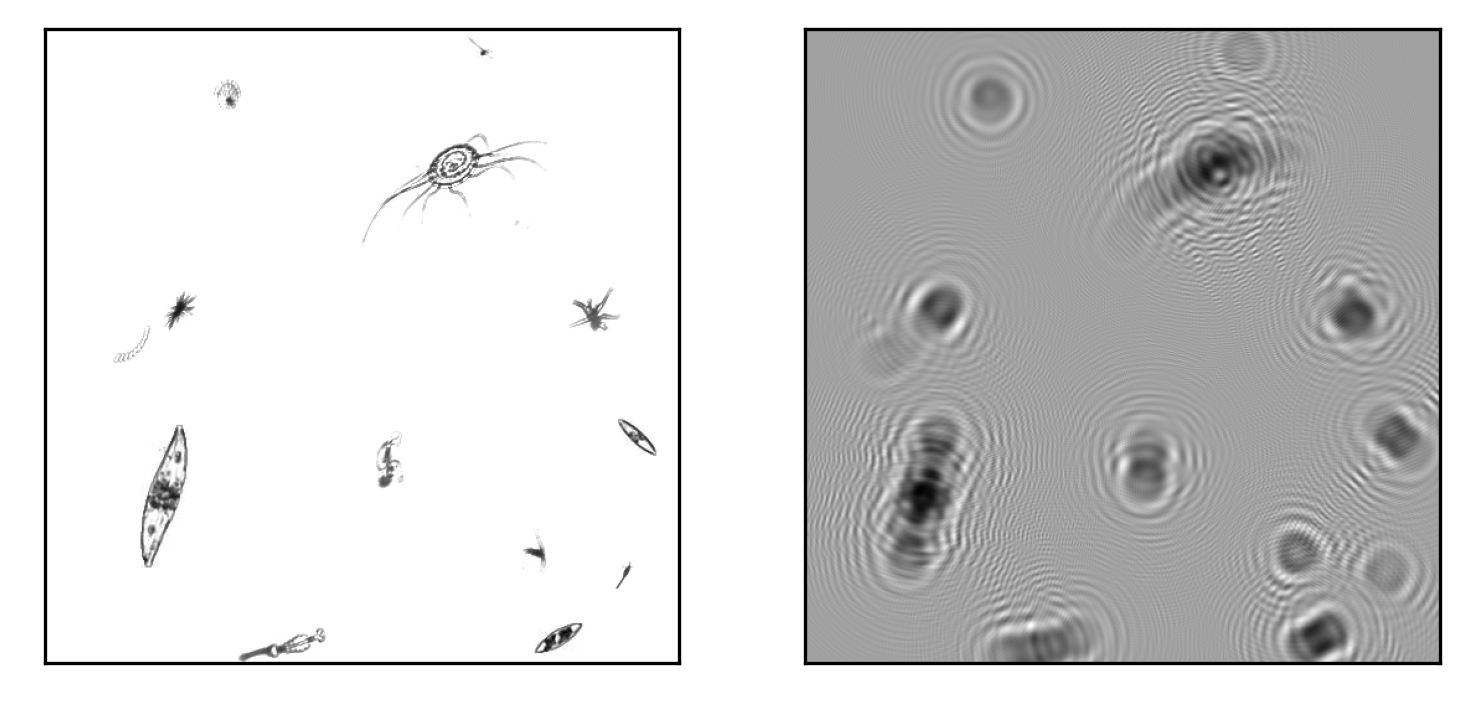

In [16]:
imshowpair(Canvas,Holo)


# Show the BBox coords and the labels on the Canvas

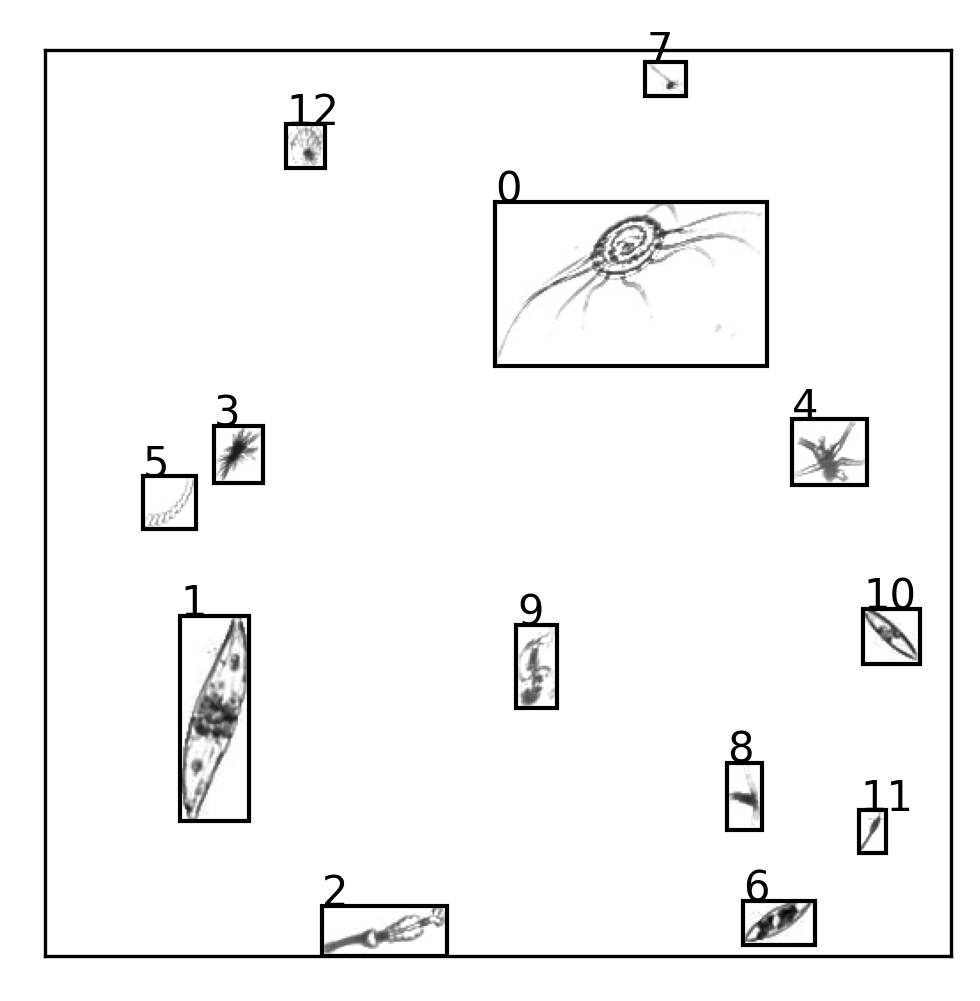

In [17]:
plotbbox(Canvas,Coor,Classe,color='k',dpi=100)

## Simulate a dataset 

In [25]:
NBSIM = 10 # number of images to simulate



Path = "dataset/train/"
pathLab = "Images/Holo/train/labels/"
pathIm = "Images/Holo/train/images/"
pathCanvas = 'Images/Canvas/train/images/'

for i in tqdm(range(NBSIM)):
    name = pathLab + "im"+ str(i)+".txt"
    nameHolo = pathIm +"im"+str(i) + ".png"
    nameCanvas = pathCanvas +"im"+str(i) + ".png"
    Canvas,Coor,Classe = createCanvasBreaking(N,PathClasses,Path,nb)
    createTxt(name,Coor,Classe) # save the label for yoloV5 (class id, xc,yc,w,h ) normalize

    holo = simulationHolo(Canvas,pixelsize,Lambda,z)
    holo = np.round(holo*255)
    holo = np.expand_dims(holo,-1)
    holo = holo.astype(np.uint8)
    d = np.concatenate((holo,holo,holo),axis=-1)

    # save HOLO
    im = Image.fromarray(d)
    im.save(nameHolo)

    # save Canvas

    im = Image.fromarray((Canvas*255).astype(np.uint8))
    im.save(nameCanvas)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]
